In [233]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,Model
from tensorflow.keras.optimizers import Adam
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

In [234]:
train_dir ='/content/dataset/test'
test_dir  = '/content/dataset/train'

IMG_SIZE = (286,286)


In [235]:
def load_images_from_folder(folder):
    images = []
    for file in sorted(os.listdir(folder)):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(folder, file)
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            # Normalize to [0, 1] float here
            img = img.astype(np.float32) / 255.0
            images.append(img)
    return np.array(images)

In [236]:
x_train = load_images_from_folder(train_dir)
x_test  = load_images_from_folder(test_dir)

print("Train:", x_train.shape)
print("Test :", x_test.shape)


Train: (214, 286, 286, 3)
Test : (88, 286, 286, 3)


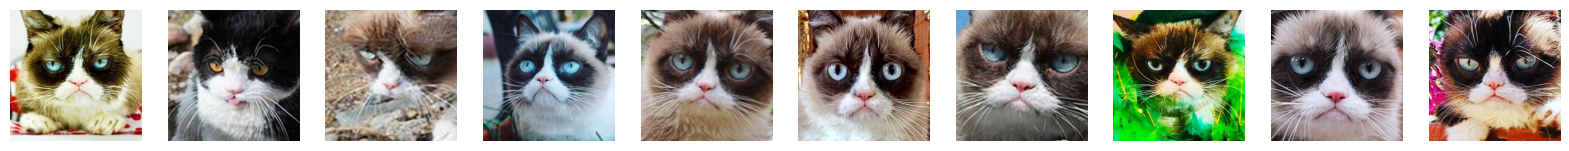

In [241]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_train[i].squeeze())
    ax.axis("off")

In [207]:
def c7Ak(x, k):
    x = layers.Conv2D(
        k, kernel_size=7, strides=1,
        padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


In [208]:
def dk(x, k):
    x = layers.Conv2D(
        k, kernel_size=3, strides=2,
        padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


In [209]:
def Rk(x, use_dropout=False):
    k = x.shape[-1]
    shortcut = x

    x = layers.Conv2D(
        k, kernel_size=3,
        padding='same'

    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    if use_dropout:
        x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(
        k, kernel_size=3,
        padding='same'
    )(x)
    x = layers.BatchNormalization()(x)

    return layers.Add()([shortcut, x])


In [210]:
def uk(x, k):
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(
        k, kernel_size=3,
        padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


In [212]:
def build_resnet_autoencoder(
    img_shape=(286,286, 3),
    n_res_blocks=9
):
    inputs = layers.Input(shape=img_shape)

    # -------- Encoder --------
    x = c7Ak(inputs, 32)      # 286 → 286
    x = dk(x, 64)             # 286 → 143
    x = dk(x, 128)            # 143 → 72

    # -------- Bottleneck --------
    for _ in range(n_res_blocks):
        x = Rk(x)

    # -------- Decoder --------
    x = uk(x, 64)             # 72 → 144
    x = uk(x, 32)             # 144 → 288

    # -------- Output --------
    x = layers.Conv2D(
        img_shape[-1],
        kernel_size=7,
        padding='same',
        activation='tanh',
        use_bias=True
    )(x)

    outputs = layers.Cropping2D(((1, 1), (1, 1)))(x)  # 288 → 286

    return models.Model(inputs, outputs, name="ResNet_AE_286_bias")


In [213]:
model = build_resnet_autoencoder()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    loss='mse'
)




In [214]:
x_train = (x_train * 2.0) - 1.0
x_test  = (x_test  * 2.0) - 1.0


In [215]:
history = model.fit(
    x_train, x_train,
    epochs=50,
    batch_size=4,
    validation_data=(x_test, x_test),
    shuffle=True,

)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 354ms/step - loss: 0.1435 - val_loss: 0.1118
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0311 - val_loss: 0.0882
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0304 - val_loss: 0.0639
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 0.0254 - val_loss: 0.0469
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0255 - val_loss: 0.0485
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 0.0246 - val_loss: 0.0175
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - loss: 0.0242 - val_loss: 0.0183
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - loss: 0.0208 - val_loss: 0.0095
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 0.0202 - val_loss: 0.0187
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - loss: 0.0192 - val_loss: 0.0102
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 0.0186 - val_loss: 0.0083
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/ste

In [216]:
x_test_recon = model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


In [217]:
mse_scores = []
for i in range(len(x_test)):
    mse = mean_squared_error(
        x_test[i].flatten(),
        x_test_recon[i].flatten()
    )
    mse_scores.append(mse)

print("Average MSE:", np.mean(mse_scores))

Average MSE: 0.008369704975683073


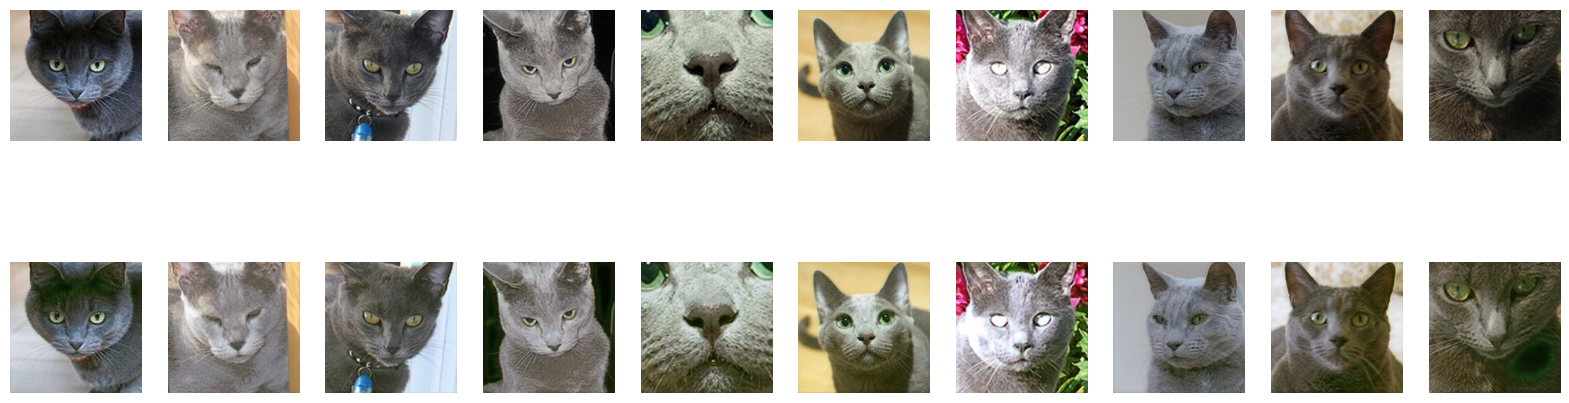

In [224]:
n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    # ----- Original -----
    ax = plt.subplot(2, n, i + 1)
    img = (x_test[i] + 1) / 2
    plt.imshow(img)
    ax.axis("off")

    # ----- Reconstruction -----
    ax = plt.subplot(2, n, i + n + 1)
    recon = (x_test_recon[i] + 1) / 2
    plt.imshow(recon)
    ax.axis("off")

plt.show()


In [219]:
ssim_scores = []
for i in range(len(x_test)):
    ssim_val = ssim(
        x_test[i].squeeze(),
        x_test_recon[i].squeeze(),
        data_range=1.0,
        channel_axis=2
    )
    ssim_scores.append(ssim_val)

print("Average SSIM:", np.mean(ssim_scores))

Average SSIM: 0.7594036
